# Separating signal and noise – how to use alphalens

Quantopian has open sourced the Python library, alphalens, for the performance analysis of predictive stock factors that integrates well with the backtesting library zipline and the portfolio performance and risk analysis library pyfolio that we will explore in the next chapter.
alphalens facilitates the analysis of the predictive power of alpha factors concerning the:
- Correlation of the signals with subsequent returns
- Profitability of an equal or factor-weighted portfolio based on a (subset of) the signals
- Turnover of factors to indicate the potential trading costs
- Factor-performance during specific events
- Breakdowns of the preceding by sector

The analysis can be conducted using tearsheets or individual computations and plots.

## Imports & Settings

In [1]:
import re
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from alphalens.utils import get_clean_factor_and_forward_returns
from alphalens.performance import *
from alphalens.plotting import *
from alphalens.tears import *

In [2]:
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('fivethirtyeight')

## Creating forward returns and factor quantiles

To utilize `alpahalens`, we need to provide signals for a universe of assets like those returned by the ranks of the MeanReversion factor, and the forward returns earned by investing in an asset for a given holding period. .

We will recover the prices from the single_factor.pickle file as follows (factor_data accordingly):

In [3]:
performance = pd.read_pickle('single_factor.pickle')

In [4]:
prices = pd.concat([df.to_frame(d) for d, df in performance.prices.items()],axis=1).T
prices.columns = [re.findall(r"\[(.+)\]", str(col))[0] for col in prices.columns]
prices.index = prices.index.normalize()
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 755 entries, 2015-01-02 to 2017-12-29
Columns: 1649 entries, A to ZTS
dtypes: float64(1649)
memory usage: 9.5 MB


In [5]:
factor_data = pd.concat([df.to_frame(d) for d, df in performance.factor_data.items()],axis=1).T
factor_data.columns = [re.findall(r"\[(.+)\]", str(col))[0] for col in factor_data.columns]
factor_data.index = factor_data.index.normalize()
factor_data = factor_data.stack()
factor_data.index.names = ['date', 'asset']
factor_data.head()

date                       asset
2015-01-02 00:00:00+00:00  A        2618.0
                           AAL      1088.0
                           AAP       791.0
                           AAPL     2917.0
                           ABBV     2952.0
dtype: float64

In [10]:
with pd.HDFStore('../../data/assets.h5') as store:
    sp500 = store['sp500/prices'].close
sp500 = sp500.resample('D').ffill().tz_localize('utc').filter(prices.index.get_level_values(0))
sp500.head()

date
2015-01-02 00:00:00+00:00    2058.20
2015-01-05 00:00:00+00:00    2020.58
2015-01-06 00:00:00+00:00    2002.61
2015-01-07 00:00:00+00:00    2025.90
2015-01-08 00:00:00+00:00    2062.14
Name: close, dtype: float64

We can create the alphalens input data in the required format using the `get_clean_factor_and_forward_returns` utility function that also returns the signal quartiles and the forward returns for the given holding periods:

In [11]:
HOLDING_PERIODS = (5, 10, 21, 42)
QUANTILES = 5
alphalens_data = get_clean_factor_and_forward_returns(factor=factor_data,
                                                      prices=prices,
                                                      periods=HOLDING_PERIODS,
                                                      quantiles=QUANTILES)

Dropped 14.7% entries from factor data: 14.7% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


The `alphalens_data` `DataFrame` contains the returns on an investment in the given asset on a given date for the indicated holding period, as well as the factor value, that is, the asset's `MeanReversion` ranking on that date, and the corresponding quantile value:

In [12]:
alphalens_data.head()

5D       10D       21D       42D  \
date                      asset                                           
2015-01-02 00:00:00+00:00 A     -0.018738 -0.011095 -0.046105  0.052761   
                          AAL   -0.000649 -0.080319 -0.096272 -0.103877   
                          AAP   -0.013181  0.002334 -0.016335 -0.023903   
                          AAPL  -0.028172 -0.000732  0.085064  0.180737   
                          ABBV  -0.018819 -0.001973 -0.078768 -0.082410   

                                 factor  factor_quantile  
date                      asset                           
2015-01-02 00:00:00+00:00 A      2618.0                4  
                          AAL    1088.0                2  
                          AAP     791.0                1  
                          AAPL   2917.0                5  
                          ABBV   2952.0                5

The forward returns and the signal quantiles are the basis for evaluating the predictive power of the signal. Typically, a factor should deliver markedly different returns for distinct quantiles, such as negative returns for the bottom quintile of the factor values and positive returns for the top quantile.

## Summary Tear Sheet

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,1.0,1067.0,305.535714,189.870100,128886,20.043201
2,336.0,1704.0,851.172613,241.578479,128455,19.976176
3,774.0,2235.0,1407.919172,271.315212,128482,19.980375
4,1251.0,2629.0,1970.136336,263.386563,128455,19.976176
5,1794.0,3056.0,2512.624224,230.124891,128763,20.024073


Returns Analysis


,5D,10D,21D,42D
Ann. alpha,0.036,0.033,0.011,-0.001
beta,0.064,0.079,0.064,0.016
Mean Period Wise Return Top Quantile (bps),6.346,7.090,3.258,-0.771
Mean Period Wise Return Bottom Quantile (bps),-14.600,-11.865,-4.957,-1.571
Mean Period Wise Spread (bps),20.946,18.968,8.246,0.805


Information Analysis


,5D,10D,21D,42D
IC Mean,0.021,0.025,0.015,0.001
IC Std.,0.144,0.130,0.120,0.120
Risk-Adjusted IC,0.145,0.191,0.127,0.010
t-stat(IC),3.861,5.107,3.396,0.266
p-value(IC),0.000,0.000,0.001,0.790
IC Skew,0.384,0.251,0.115,0.134
IC Kurtosis,0.019,-0.584,-0.353,-0.494


Turnover Analysis


,10D,21D,42D,5D
Quantile 1 Mean Turnover,0.587,0.826,0.828,0.410
Quantile 2 Mean Turnover,0.737,0.801,0.810,0.644
Quantile 3 Mean Turnover,0.764,0.803,0.808,0.679
Quantile 4 Mean Turnover,0.737,0.803,0.808,0.641
Quantile 5 Mean Turnover,0.565,0.802,0.809,0.393


,5D,10D,21D,42D
Mean Factor Rank Autocorrelation,0.713,0.454,-0.011,-0.016


<Figure size 432x288 with 0 Axes>

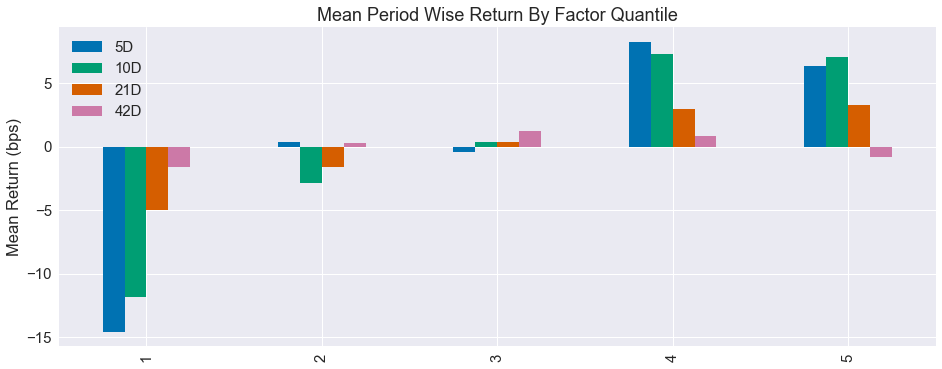

In [13]:
create_summary_tear_sheet(alphalens_data)

## Predictive performance by factor quantiles -  Returns Analysis

As a first step, we would like to visualize the average period return by factor quantile. We can use the built-in function mean_return_by_quantile from the performance and plot_quantile_returns_bar from the plotting modules

In [14]:
mean_return_by_q, std_err = mean_return_by_quantile(alphalens_data)
mean_return_by_q_norm = mean_return_by_q.apply(lambda x: x.add(1).pow(1/int(x.name[:-1])).sub(1))

### Mean Return by Holding Period and Quintile

The result is a bar chart that breaks down the mean of the forward returns for the four different holding periods based on the quintile of the factor signal. As you can see, the bottom quintiles yielded markedly more negative results than the top quintiles, except for the longest holding period:


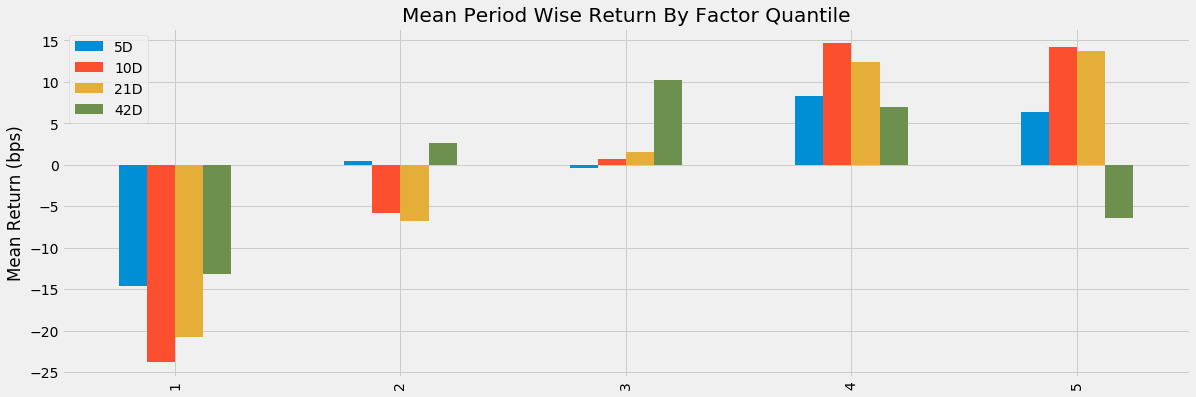

In [27]:
plot_quantile_returns_bar(mean_return_by_q)
# plt.savefig('mean_return', dpi=300);

The 10D holding period provides slightly better results for the first and fourth quartiles. We would also like to see the performance over time of investments driven by each of the signal quintiles. 

We will calculate daily, as opposed to average returns for the 5D holding period, and alphalens will adjust the period returns to account for the mismatch between daily signals and a longer holding period (for details, see docs):

In [28]:
mean_return_by_q_daily, std_err = mean_return_by_quantile(alphalens_data, by_date=True)

### Cumulative 5D Return

The resulting line plot shows that, for most of this three-year period, the top two quintiles significantly outperformed the bottom two quintiles. However, as suggested by the previous plot, signals by the fourth quintile produced a better performance than those by the top quintile

In [ ]:
plot_cumulative_returns_by_quantile(mean_return_by_q_daily['5D'], period='5D', freq='Day')

### Return Distribution by Holding Period and Quintile

This distributional plot highlights that the range of daily returns is fairly wide and, despite different means, the separation of the distributions is very limited so that, on any given day, the differences in performance between the different quintiles may be rather limited:

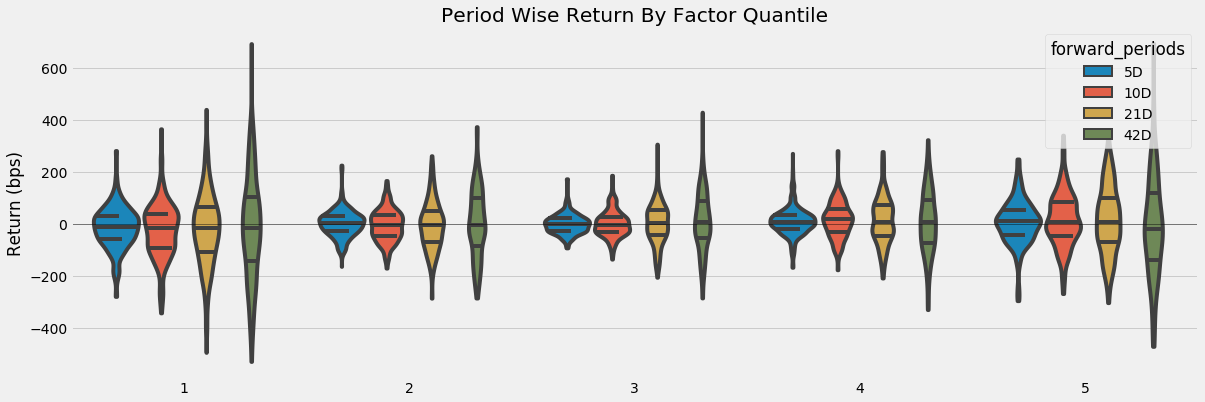

In [22]:
plot_quantile_returns_violin(mean_return_by_q_daily)
# plt.savefig('mean_ret', dpi=300);

## Information Coefficient

Most of this book is about the design of alpha factors using ML models. ML is about optimizing some predictive objective, and in this section, we will introduce the key metrics used to measure the performance of an alpha factor. We will define alpha as the average return in excess of a benchmark.
This leads to the information ratio (IR) that measures the average excess return per unit of risk taken by dividing alpha by the tracking risk. When the benchmark is the risk-free rate, the IR corresponds to the well-known Sharpe ratio, and we will highlight crucial statistical measurement issues that arise in the typical case when returns are not normally distributed. We will also explain the fundamental law of active management that breaks the IR down into a combination of forecasting skill and a strategy's ability to effectively leverage the forecasting skills.

### 5D Information Coefficient (Rolling Average)

The goal of alpha factors is the accurate directional prediction of future returns. Hence, a natural performance measure is the correlation between an alpha factor's predictions and the forward returns of the target assets. 

It is better to use the non-parametric Spearman rank correlation coefficient that measures how well the relationship between two variables can be described using a monotonic function, as opposed to the Pearson correlation that measures the strength of a linear relationship. 

We can obtain the information coefficient using alphalens, which relies on `scipy.stats.spearmanr` under the hood. 

The `factor_information_coefficient` function computes the period-wise correlation and plot_ic_ts creates a time-series plot with one-month moving average:

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fdf5a0511d0>],
      dtype=object)

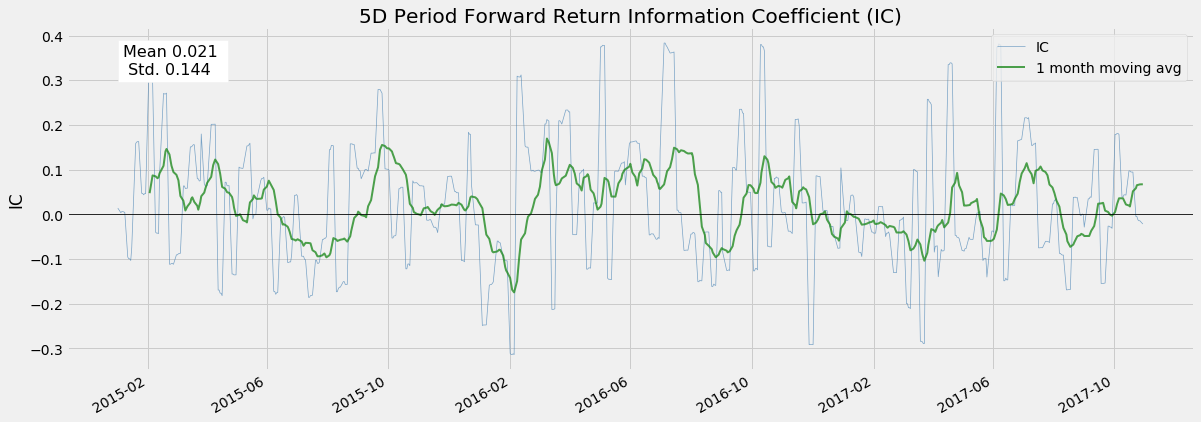

In [23]:
ic = factor_information_coefficient(alphalens_data)
plot_ic_ts(ic[['5D']])
# plt.savefig('violin', dpi=300);

#### Information Coefficient by Holding Period

This time series plot shows extended periods with significantly positive moving-average IC. An IC of 0.05 or even 0.1 allows for significant outperformance if there are sufficient opportunities to apply this forecasting skill, as the fundamental law of active management will illustrate:

A plot of the annual mean IC highlights how the factor's performance was historically uneven:

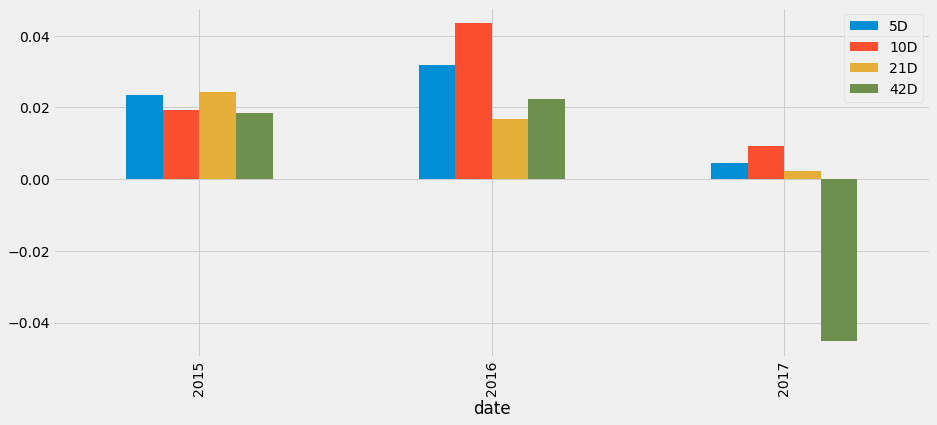

In [24]:
ic = factor_information_coefficient(alphalens_data)
ic_by_year = ic.resample('A').mean()
ic_by_year.index = ic_by_year.index.year
ic_by_year.plot.bar(figsize=(14, 6))
# plt.savefig('ic', dpi=300);

### Summary Tear Sheet

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,1.0,1067.0,305.535714,189.870100,128886,20.043201
2,336.0,1704.0,851.172613,241.578479,128455,19.976176
3,774.0,2235.0,1407.919172,271.315212,128482,19.980375
4,1251.0,2629.0,1970.136336,263.386563,128455,19.976176
5,1794.0,3056.0,2512.624224,230.124891,128763,20.024073


Returns Analysis


,5D,10D,21D,42D
Ann. alpha,0.036,0.033,0.011,-0.001
beta,0.064,0.079,0.064,0.016
Mean Period Wise Return Top Quantile (bps),6.346,7.090,3.258,-0.771
Mean Period Wise Return Bottom Quantile (bps),-14.600,-11.865,-4.957,-1.571
Mean Period Wise Spread (bps),20.946,18.968,8.246,0.805


Information Analysis


,5D,10D,21D,42D
IC Mean,0.021,0.025,0.015,0.001
IC Std.,0.144,0.130,0.120,0.120
Risk-Adjusted IC,0.145,0.191,0.127,0.010
t-stat(IC),3.861,5.107,3.396,0.266
p-value(IC),0.000,0.000,0.001,0.790
IC Skew,0.384,0.251,0.115,0.134
IC Kurtosis,0.019,-0.584,-0.353,-0.494


Turnover Analysis


,10D,21D,42D,5D
Quantile 1 Mean Turnover,0.587,0.826,0.828,0.410
Quantile 2 Mean Turnover,0.737,0.801,0.810,0.644
Quantile 3 Mean Turnover,0.764,0.803,0.808,0.679
Quantile 4 Mean Turnover,0.737,0.803,0.808,0.641
Quantile 5 Mean Turnover,0.565,0.802,0.809,0.393


,5D,10D,21D,42D
Mean Factor Rank Autocorrelation,0.713,0.454,-0.011,-0.016


<Figure size 432x288 with 0 Axes>

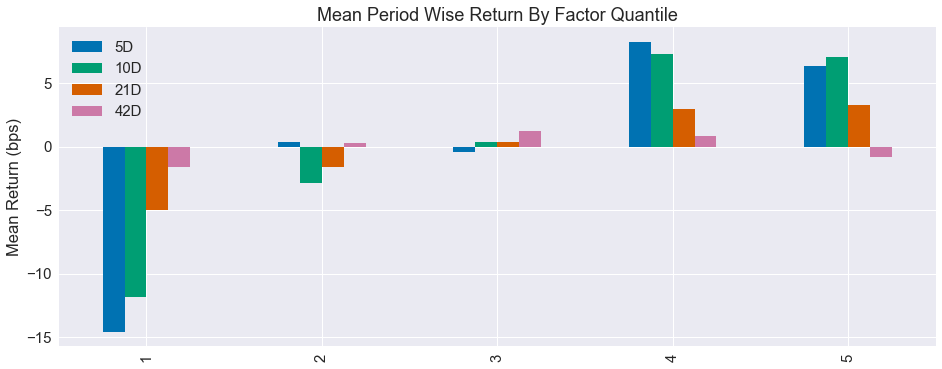

In [25]:
create_summary_tear_sheet(alphalens_data);

### Turnover Tear Sheet

Factor turnover measures how frequently the assets associated with a given quantile change, that is, how many trades are required to adjust a portfolio to the sequence of signals. More specifically, it measures the share of assets currently in a factor quantile that was not in that quantile in the last period.

Turnover Analysis


,10D,21D,42D,5D
Quantile 1 Mean Turnover,0.587,0.826,0.828,0.410
Quantile 2 Mean Turnover,0.737,0.801,0.810,0.644
Quantile 3 Mean Turnover,0.764,0.803,0.808,0.679
Quantile 4 Mean Turnover,0.737,0.803,0.808,0.641
Quantile 5 Mean Turnover,0.565,0.802,0.809,0.393


,5D,10D,21D,42D
Mean Factor Rank Autocorrelation,0.713,0.454,-0.011,-0.016


<Figure size 432x288 with 0 Axes>

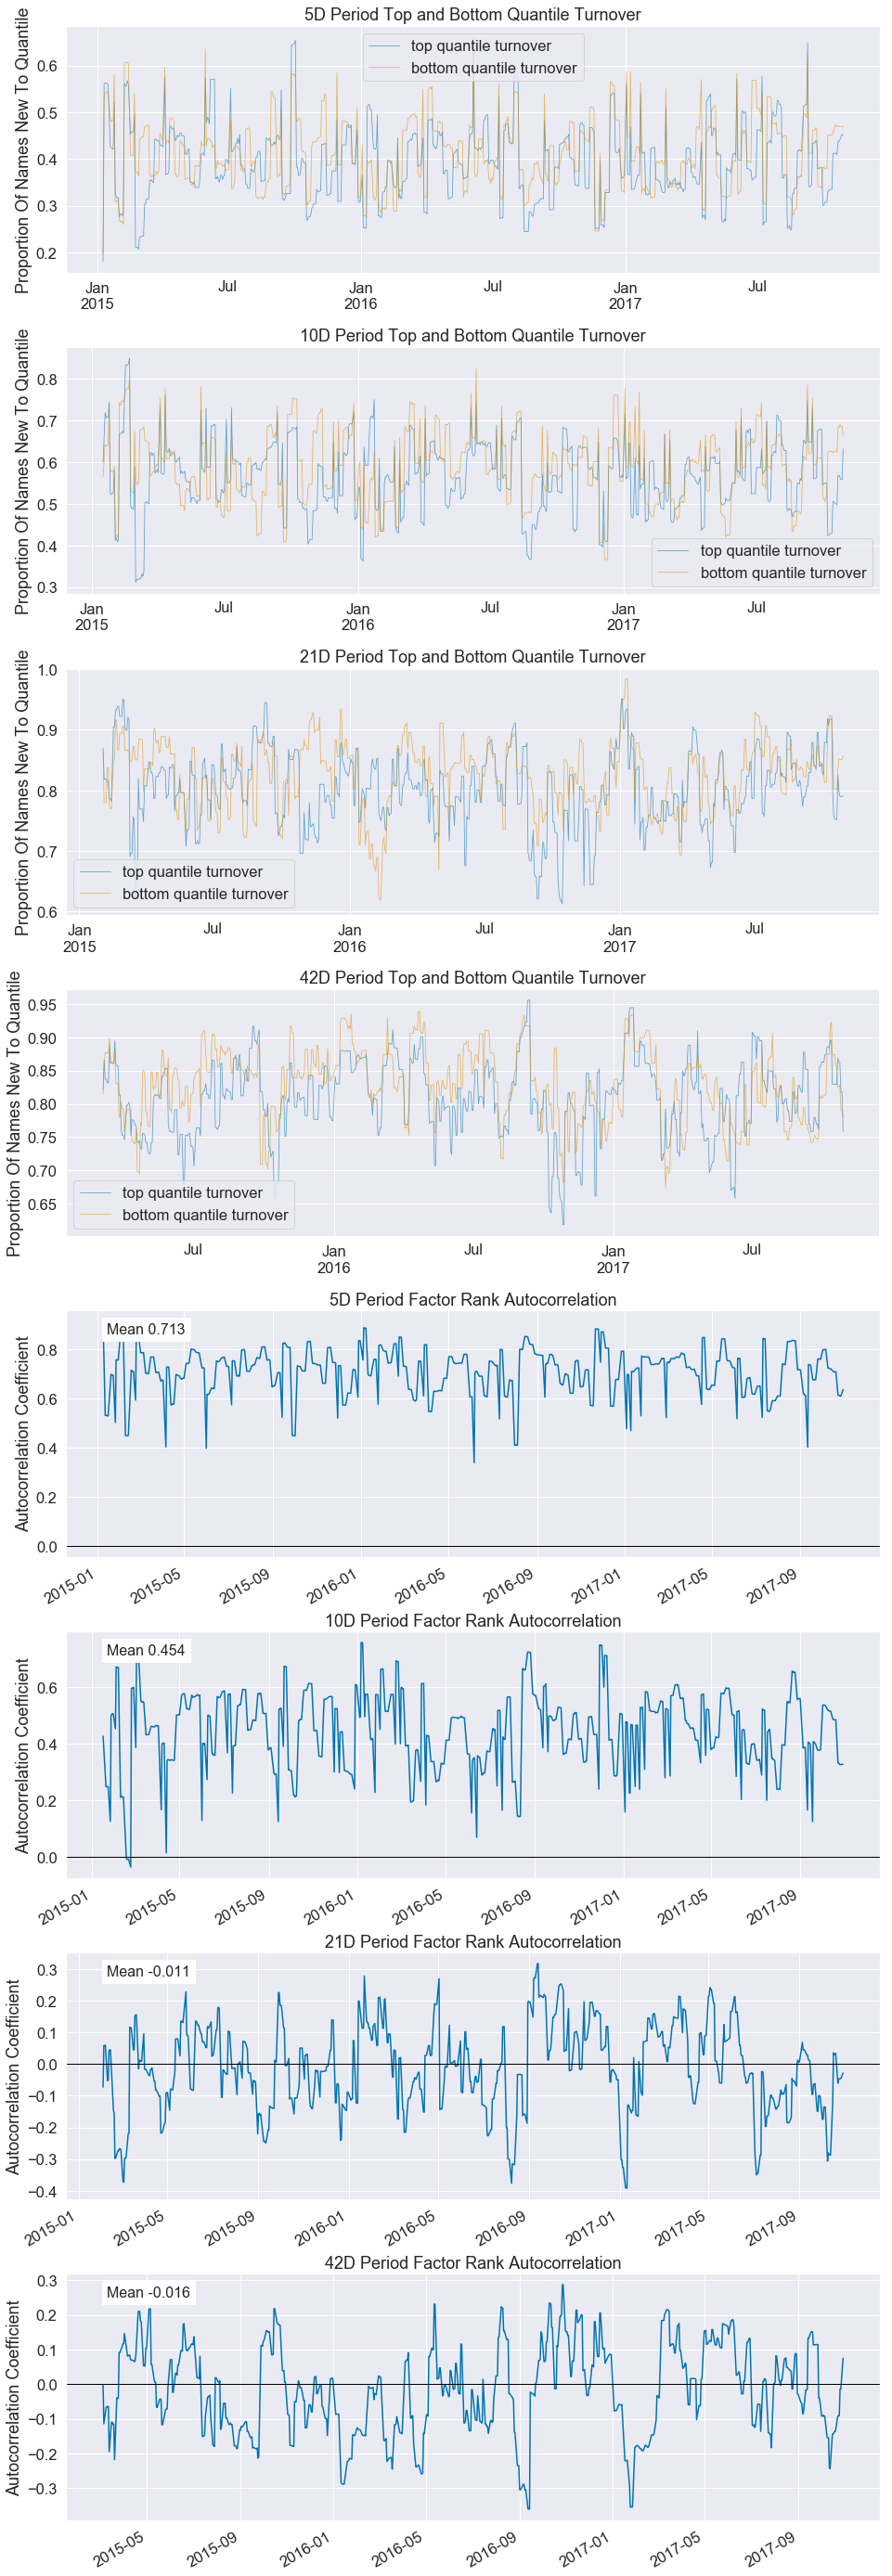

In [27]:
create_turnover_tear_sheet(alphalens_data);